In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split

import os
import matplotlib.pyplot as plt
import numpy as np

from model import MLP, MLP_RES, CNN_RES
from dataset import BurgersDataset, train_split_files
from config import (
    DATA_DIR,
    MODEL_PATH,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_files, val_files = train_split_files()

train_dataset = BurgersDataset(file_paths=train_files)
val_dataset = BurgersDataset(file_paths=val_files)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Found 169 simulations.
Splitting into 84 training and 85 validation files.


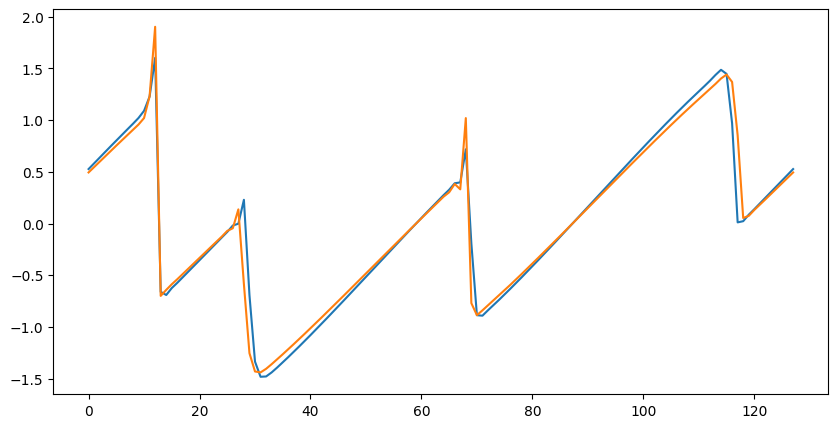

In [24]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample
#plot 
plt.figure(figsize=(10,5))
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0].numpy(), label='Target')

In [25]:
# model = MLP_RES(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)
# model.to(device)


# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

# model.eval()
# with torch.no_grad():
#     x, y = next(iter(val_loader))
#     y_pred = model(x)
#     val_loss = criterion(y_pred, y).item()
# print(f"{val_loss}")

In [ ]:
def train(criterion, optimizer, scheduler, model, train_loader, val_loader, device):

    best_val_loss = float("inf")
    loss_history = {"train": [], "val": []}
    print("Starting training...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                val_loss += criterion(y_pred, y).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"New best model found at epoch {epoch+1} with val loss {best_val_loss:.6f}")
        
        # Get the current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']
        
        print(
            f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {avg_train:.6f}, "
            f"Val Loss: {avg_val:.6f}, "
            f"LR: {current_lr:.8f}"
        )

        loss_history["train"].append(avg_train)
        loss_history["val"].append(avg_val)

        # Step the scheduler at the end of each epoch
        scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    print("Finished training.")

    return loss_history

In [27]:
LR = 1e-4
EPOCHS = 250

model = MLP_RES(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

if not os.path.exists("models/MLP_RES.pth"):
    loss_history = train(criterion, optimizer, scheduler, model, train_loader, val_loader, device)
    torch.save(model.state_dict(), "models/MLP_RES.pth")
    print(f"Model saved")
else:
    model.load_state_dict(torch.load("models/MLP_RES.pth"))
    model.eval()
    print("Model loaded")

Starting training...
New best model found at epoch 1 with val loss 0.006578
Epoch 1/250, Train Loss: 0.012478, Val Loss: 0.006578, LR: 0.00010000
New best model found at epoch 2 with val loss 0.006205
Epoch 2/250, Train Loss: 0.006200, Val Loss: 0.006205, LR: 0.00010000
New best model found at epoch 3 with val loss 0.005877
Epoch 3/250, Train Loss: 0.005905, Val Loss: 0.005877, LR: 0.00009998
Epoch 4/250, Train Loss: 0.005731, Val Loss: 0.005956, LR: 0.00009996
Epoch 5/250, Train Loss: 0.005683, Val Loss: 0.005890, LR: 0.00009994
Epoch 6/250, Train Loss: 0.005599, Val Loss: 0.006222, LR: 0.00009990
New best model found at epoch 7 with val loss 0.005722
Epoch 7/250, Train Loss: 0.005543, Val Loss: 0.005722, LR: 0.00009986
Epoch 8/250, Train Loss: 0.005462, Val Loss: 0.005775, LR: 0.00009981
Epoch 9/250, Train Loss: 0.005421, Val Loss: 0.005841, LR: 0.00009975
Epoch 10/250, Train Loss: 0.005354, Val Loss: 0.005827, LR: 0.00009968
New best model found at epoch 11 with val loss 0.005620
Ep

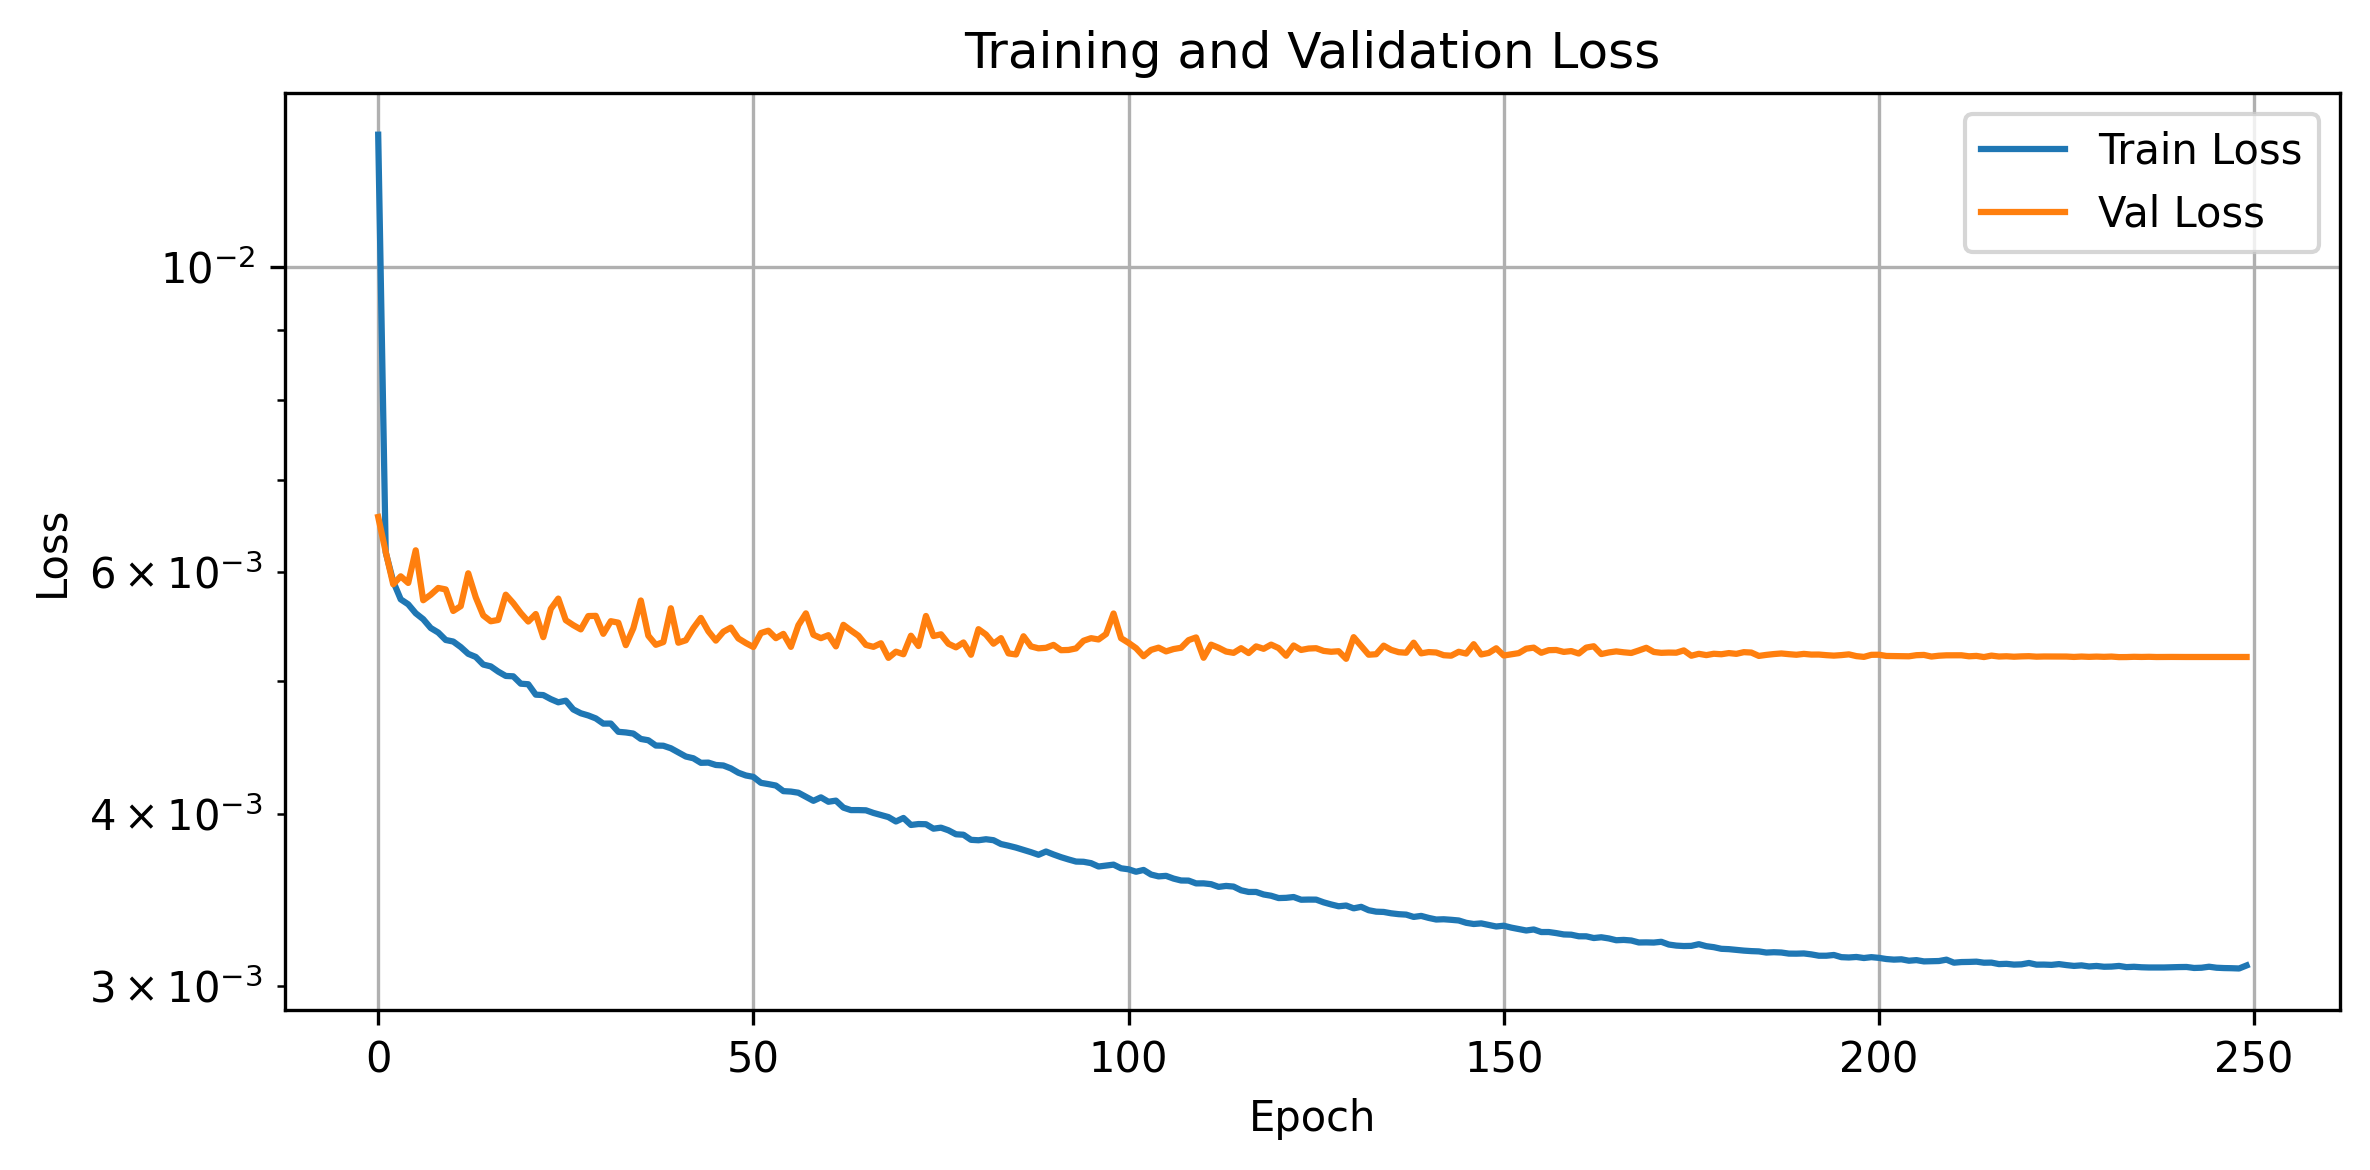

In [28]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(loss_history["train"], label="Train Loss")
plt.plot(loss_history["val"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.yscale("log")
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [35]:
NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE
)
model.to(device)

LR = 1e-4
EPOCHS = 250

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-8)

if not os.path.exists("models/CNN_RES.pth"):
    loss_history = train(criterion, optimizer, scheduler, model, train_loader, val_loader, device)
    torch.save(model.state_dict(), "models/CNN_RES.pth")
    print(f"Model saved")
else:
    model.load_state_dict(torch.load("models/CNN_RES.pth"))
    model.eval()
    print("Model loaded")

Model loaded


/tmp/ipykernel_10454/4129103307.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/CNN_RES.pth"))


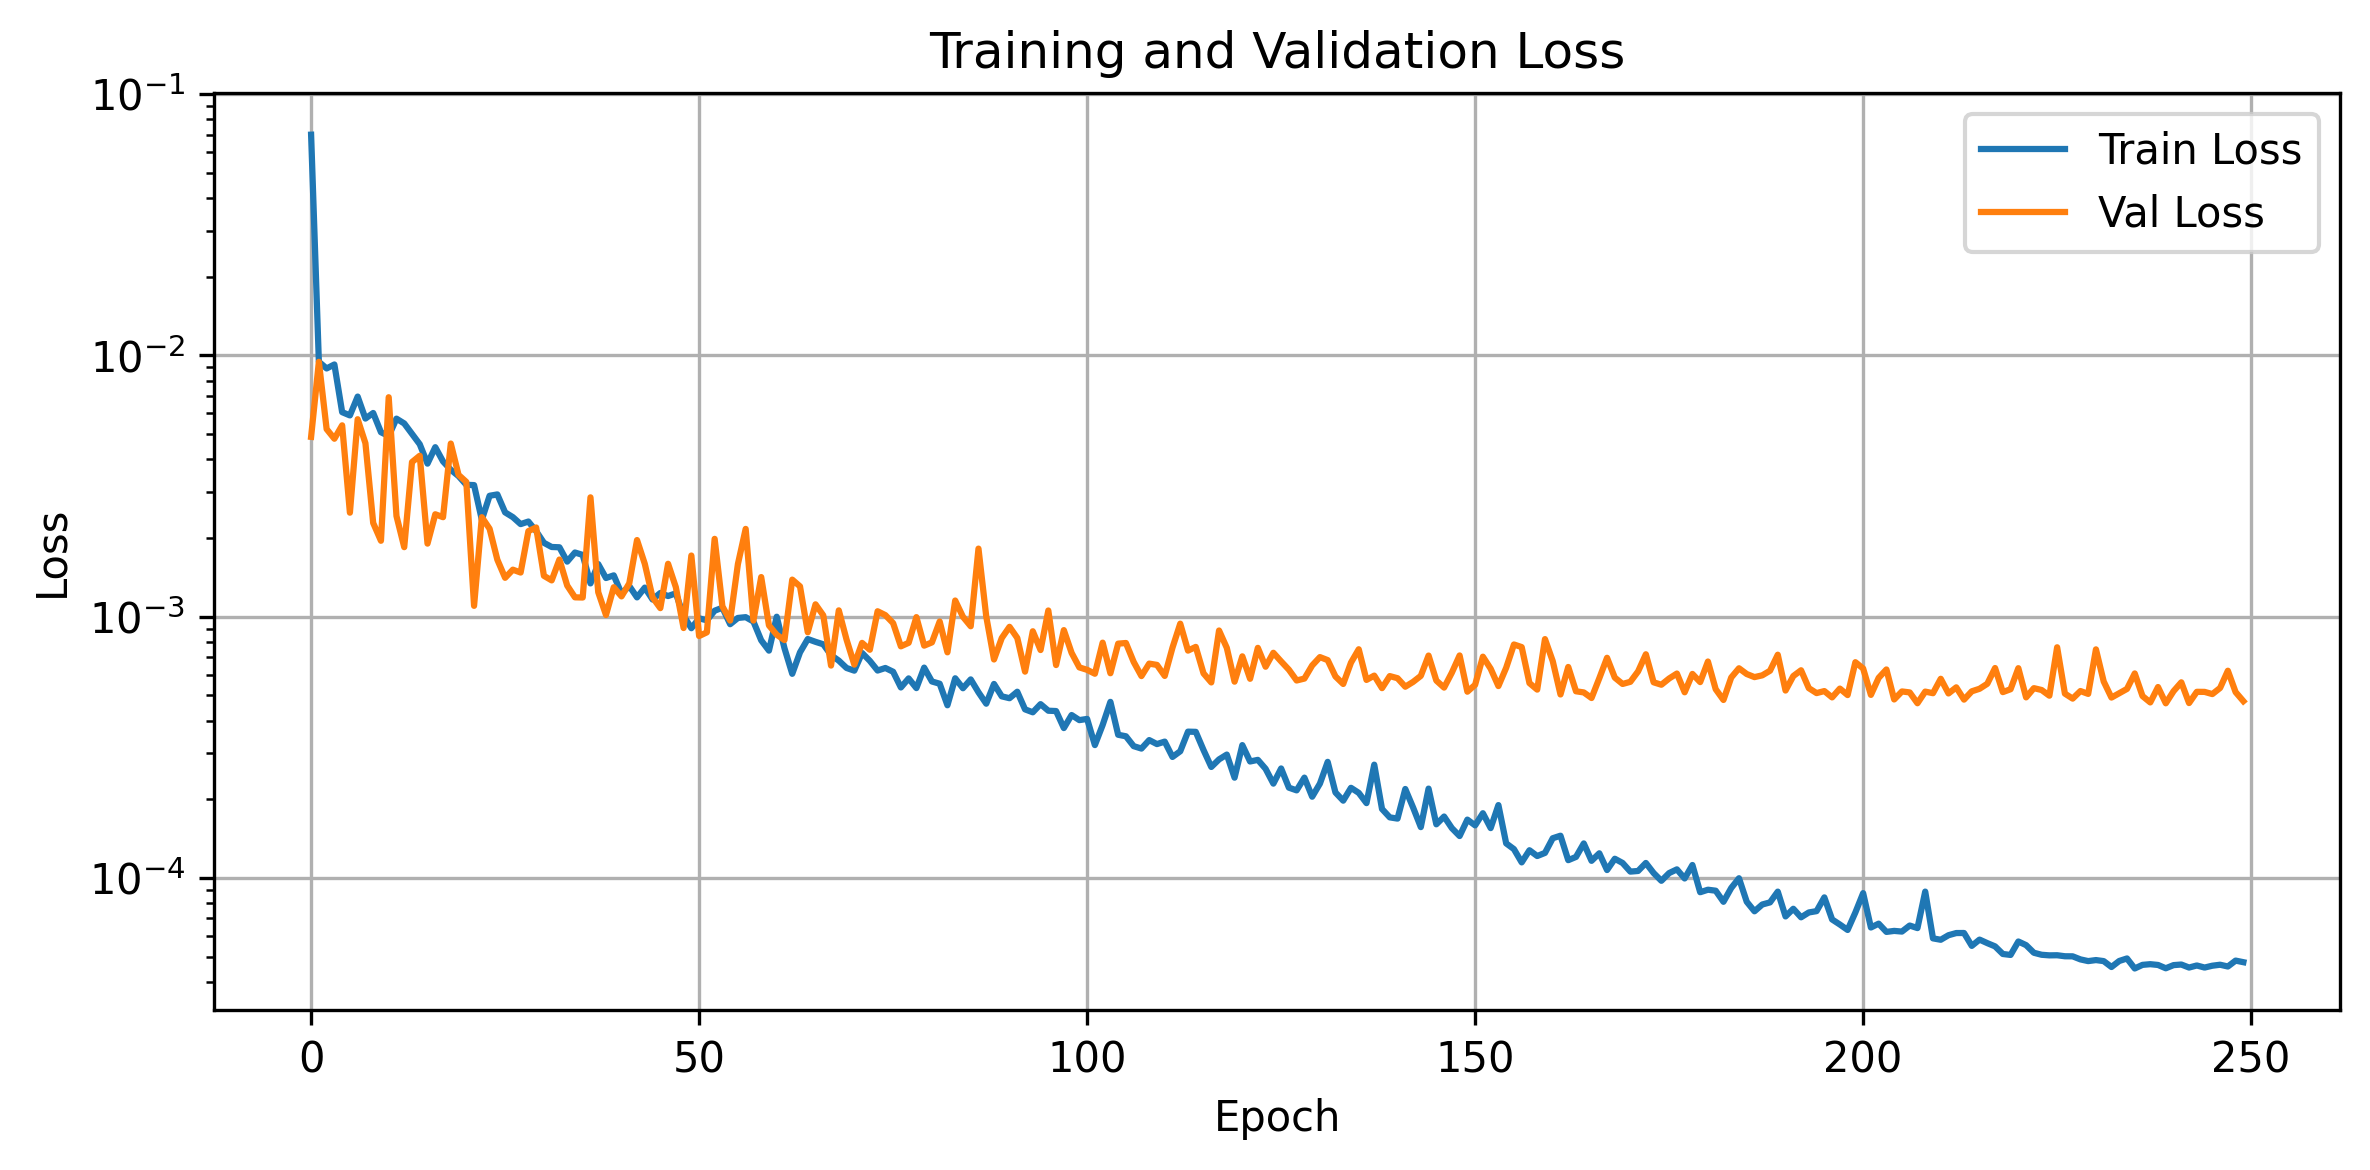

In [30]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(loss_history["train"], label="Train Loss")
plt.plot(loss_history["val"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.yscale("log")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

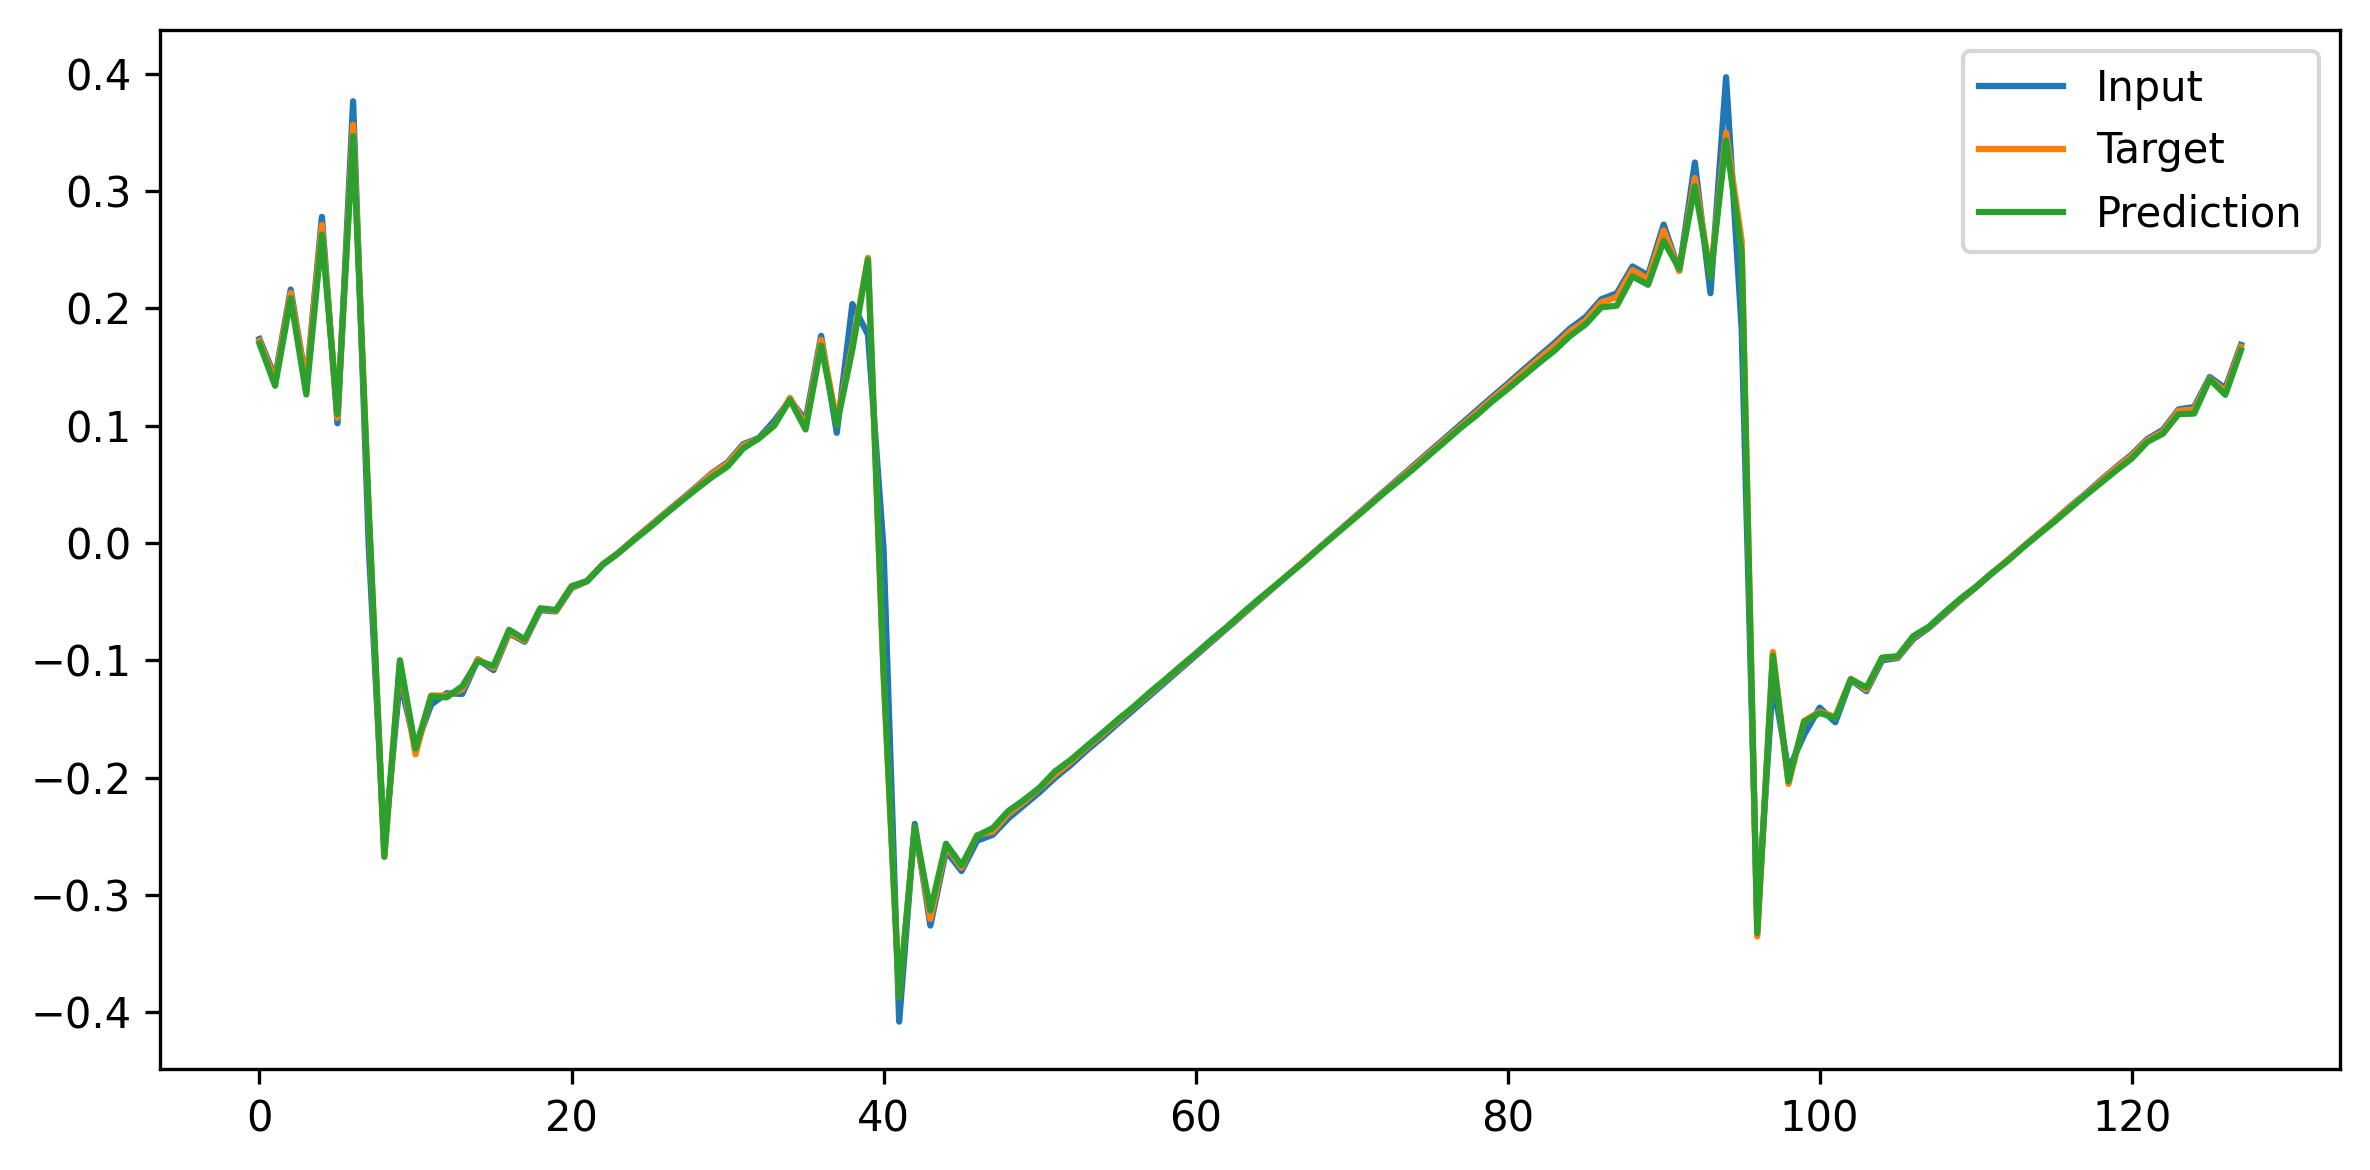

In [37]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample

x = x.to(device)
y = y.to(device)

with torch.no_grad():
	y_pred = model(x)
	
y_pred = y_pred.cpu()
x = x.cpu()
y = y.cpu()
#plot 
plt.figure(figsize=(8,4), dpi=300)
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0].numpy(), label='Target')
plt.plot(y_pred[0], label='Prediction')
plt.tight_layout()
plt.legend()

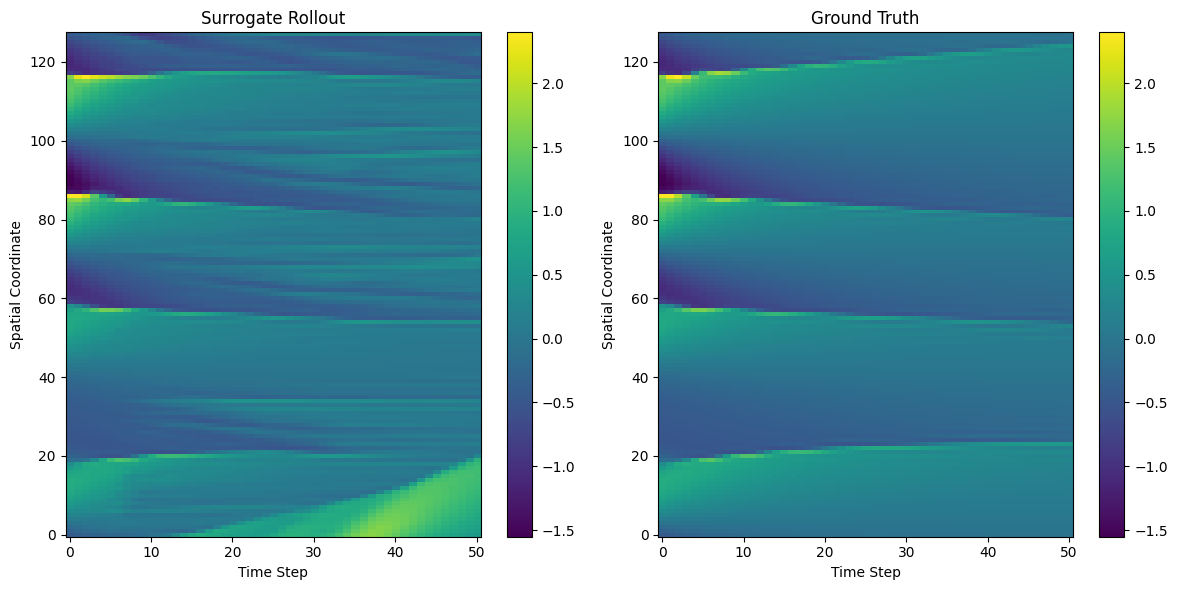

Corrected Rollout MSE over 50 steps: 0.1087


In [46]:
import numpy as np
import os

model.eval()

npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    
file_num = np.random.randint(0, len(npz_files) - 1)
data_path = os.path.join(DATA_DIR, npz_files[file_num])
raw_data = np.load(data_path)['DataGenerator-Mesh-1D-Internal']

rollout_steps = raw_data.shape[0] - 1
rollout_steps //= 2

start_index = 3

x0_np = raw_data[start_index]
ground_truth = raw_data[start_index : start_index + rollout_steps + 1]

predictions = [x0_np]
current_x = torch.from_numpy(x0_np).float().unsqueeze(0)

with torch.no_grad():
    for _ in range(rollout_steps):
        current_x = current_x.to(device)
        y_pred = model(current_x)
        predictions.append(y_pred.squeeze().cpu())
        current_x = y_pred

predictions = np.array(predictions)

vmin = ground_truth.min()
vmax = ground_truth.max()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predictions.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Surrogate Rollout')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(ground_truth.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.tight_layout()
plt.savefig('rollout_comparison.png')
plt.show()

mse = np.mean((predictions - ground_truth)**2)
print(f"Corrected Rollout MSE over {rollout_steps} steps: {mse:.4f}")